<h3>Charlie AutoEncoder</h3>

In [87]:
# @title
# Generate random symbols as input
def generate_symbols(input_length, M):
    return torch.randint(0, M, (input_length,))  # generate (batch_size) random symbols between 0 and M - 1

# Create sliding windows from input data
def create_windows(data, window_size, step_size):
    num_windows = (len(data) - window_size) // step_size + 1
    windows = torch.stack([
        data[i:i + window_size]  # Extract rows for each window
        for i in range(0, num_windows * step_size, step_size)
    ])

    return windows

def plot_two_lines(x1, y1, x2, y2, title, x_label, y_label, label1="Line 1", label2="Line 2"):
    """
    Creates an interactive Plotly plot for two solid lines over the same x-axis.

    Parameters:
    - x1, y1: Data for the first line
    - x2, y2: Data for the second line
    - title: Plot title
    - x_label: Label for the x-axis
    - y_label: Label for the y-axis
    - label1: Legend name for the first line (default: "Line 1")
    - label2: Legend name for the second line (default: "Line 2")
    """

    # Create an interactive figure
    fig = go.Figure()

    # Add first line trace (solid blue)
    fig.add_trace(go.Scatter(
        x=x1, y=y1,
        mode='lines', name=label1,
        line=dict(color='blue', width=2)  # Solid line, blue color
    ))

    # Add second line trace (solid red)
    fig.add_trace(go.Scatter(
        x=x2, y=y2,
        mode='lines', name=label2,
        line=dict(color='red', width=2)  # Solid line, red color
    ))

    # Configure layout for better visibility
    fig.update_layout(
        title=title,
        xaxis_title=x_label,
        yaxis_title=y_label,
        template="plotly_white",
        hovermode="x",  # Enables hover tool on x-axis
    )

    # Show the interactive plot
    fig.show()

def plot_losses(losses):
    plt.figure(figsize=(8, 5))
    plt.plot(losses, label="Training Loss", color="blue", alpha=0.7)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

# REMEMBER TO IMPORT: model_weights_windowed.pth, best_params_windowed.json

# MODIFIED TRAINING (INTEGRATION)

In [117]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import json
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

def loader(weights_filepath, params_filepath):
    weights = torch.load(weights_filepath, weights_only=True, map_location=torch.device('cpu'))
    with open(params_filepath, "r") as f:
        params = json.load(f)
    return weights, params

# Load model weights and parameters
weights, params = loader(
    r"C:\Users\tomha\Documents\Capstone D2 - PC\Constellation\256QAM and 256 PSK\Basic\model_weights.pth",
    r"C:\Users\tomha\Documents\Capstone D2 - PC\Constellation\256QAM and 256 PSK\Basic\best_params.json"
)

# Hyperparameters
M = 256
n = 2
window_size = 512
epochs = 100
learning_rate = 1e-4

# Define Transmitter
class Transmitter(nn.Module):
    def __init__(self, M, n):
        super(Transmitter, self).__init__()
        self.fc1 = nn.Linear(M, 8 * M)
        self.fc2 = nn.Linear(8 * M, 8 * M) # try wider model deeper
        self.fc3 = nn.Linear(8 * M, n)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define Channel
# Define the wider model
class FiberOpticFNN0(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(FiberOpticFNN0, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(dropout),  # Dropout for regularization
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),  # Batch normalization
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

class IdentityChannel(nn.Module):
    def forward(self, x):
        return x

# Define Receiver
class Receiver(nn.Module):
    def __init__(self, n, M):
        super(Receiver, self).__init__()
        self.fc1 = nn.Linear(n, 8 * M)
        self.fc2 = nn.Linear(8 * M, 8 * M)  # try wider model -> deeper
        self.fc3 = nn.Linear(8 * M, M)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=-1)

transmitter = Transmitter(M, n)

channel = FiberOpticFNN0(2 * window_size, params["hidden_dim"], n, params["dropout"])
channel.load_state_dict(weights["model weights"], strict=False)
# channel = IdentityChannel();

receiver = Receiver(n, M)

for param in transmitter.parameters():
    assert param.requires_grad
for param in channel.parameters():
    param.requires_grad = False
for param in receiver.parameters():
    assert param.requires_grad

# Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(transmitter.parameters()) + list(receiver.parameters()), lr=learning_rate)

# Training loop with batching
transmitter.train()
channel.eval()
receiver.train()
training_losses = []

for epoch in range(epochs):
  symbols = torch.randint(0, M, (window_size,))
  target_symbol = symbols[window_size // 2]
  symbols_one_hot = F.one_hot(symbols, num_classes=M).float()

  transmitted = transmitter(symbols_one_hot)

  transmitted_flat = transmitted.view(1, -1)
  received = channel(transmitted_flat)

  decoded = receiver(received)

  optimizer.zero_grad()
  loss = criterion(decoded, target_symbol.unsqueeze(0))
  loss.backward()
  optimizer.step()

  print(f"Epoch [{epoch+1}/{epochs}] - Loss: {loss.item():.4f}")
  training_losses.append(loss.item())

Epoch [1/100] - Loss: 5.4809
Epoch [2/100] - Loss: 5.5839
Epoch [3/100] - Loss: 5.5433
Epoch [4/100] - Loss: 5.5124
Epoch [5/100] - Loss: 5.4989
Epoch [6/100] - Loss: 5.5554
Epoch [7/100] - Loss: 5.5063
Epoch [8/100] - Loss: 5.6948
Epoch [9/100] - Loss: 5.5529
Epoch [10/100] - Loss: 5.5263
Epoch [11/100] - Loss: 5.6062
Epoch [12/100] - Loss: 4.8407
Epoch [13/100] - Loss: 5.5210
Epoch [14/100] - Loss: 5.5216
Epoch [15/100] - Loss: 5.6231
Epoch [16/100] - Loss: 5.6962
Epoch [17/100] - Loss: 5.6439
Epoch [18/100] - Loss: 5.6668
Epoch [19/100] - Loss: 5.4898
Epoch [20/100] - Loss: 5.4459
Epoch [21/100] - Loss: 5.5525
Epoch [22/100] - Loss: 5.6656
Epoch [23/100] - Loss: 5.6467
Epoch [24/100] - Loss: 5.5672
Epoch [25/100] - Loss: 5.6849
Epoch [26/100] - Loss: 5.7101
Epoch [27/100] - Loss: 5.6005
Epoch [28/100] - Loss: 5.4906
Epoch [29/100] - Loss: 5.8069
Epoch [30/100] - Loss: 5.5083
Epoch [31/100] - Loss: 5.5452
Epoch [32/100] - Loss: 5.6660
Epoch [33/100] - Loss: 5.5602
Epoch [34/100] - Lo

<h3>AutoEncoder Attempt #1.5 - no sliding window</h3>

In [135]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

class TransmitterRecieverModel(nn.Module):
    def __init__(self, input_size,hidden_size,channel_size,channel_func,weight_init=1):
        super().__init__()
        self.transmitter_fc1 = nn.Linear(input_size, hidden_size)
        self.transmitter_fc2 = nn.Linear(hidden_size, channel_size)

        self.reciever_fc1 = nn.Linear(channel_size, hidden_size)
        self.reciever_fc2 = nn.Linear(hidden_size, input_size)

        self.channel_function = channel_func

        init.uniform_(self.transmitter_fc1.weight,a=-weight_init,b=weight_init)
        init.uniform_(self.transmitter_fc2.weight, a=-weight_init,b=weight_init)
        init.uniform_(self.reciever_fc1.weight, a=-weight_init,b=weight_init)
        init.uniform_(self.reciever_fc2.weight,a=-weight_init,b=weight_init)

    def forward(self, x):
        transmitter_output = F.sigmoid(self.transmitter_fc1(x))
        transmitter_output = self.transmitter_fc2(transmitter_output)

        channel_output = self.channel_function(transmitter_output)

        reciever_output = F.sigmoid(self.reciever_fc1(channel_output))
        reciever_output = self.reciever_fc2(reciever_output)

        return reciever_output
    
    def evaluate(self, x):
        with torch.no_grad():
            output = F.softmax(self.forward(x),dim=-1)
            output = [torch.argmax(o).item() for o in output]
            return output


    def train_model(self,x,y,epochs=10,learning_rate=0.001):
        training_loss = []
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(),lr=learning_rate)
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = self.forward(x)
            loss = criterion(y_pred,y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.item())
            #print(f"Epoch {epoch} Loss: {loss.item()}")
        return training_loss

C:\Users\tomha\AppData\Local\Temp\ipykernel_16608\841660291.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model.evaluate(torch.tensor(input_data_one_hot,dtype=torch.float32))


Input Data: 
tensor([220, 152,  30,  90,  89,  56, 104, 184, 252,  28,  59,  70, 180, 153,
        115, 179, 231, 178, 251, 144, 103,  74,  34,  81, 115,  20, 144, 205,
         22, 208,  67, 111,  46, 167,  39, 150, 165, 239,  75, 112,  22, 246,
        162,  35, 196, 130, 205, 158,  70, 220, 216,  77,  91, 198,  39, 250,
        133,  91, 130, 248,  72,  70, 217,  38, 247, 163, 137, 223,  66, 205,
        246, 238, 109,  94, 134,  51, 144,   2, 213, 194,  39,  52,  83,  99,
         29, 111,  94, 129,   9, 120,  41, 109, 123, 110,  44,  27, 172, 152,
        231, 159,  50, 133, 168,  61, 252, 167, 251,  41, 129,  75, 200, 248,
        113,  35,  75,  37, 246, 101,  69, 151, 226, 122, 178,  83, 183,   8,
        138,  50,  34, 133,  40, 194, 191, 190,  42,  82,  14, 113,  43,   5,
        235,  24, 239, 242, 248, 108,  79, 231, 234, 101, 246,  48,  35, 120,
         78, 125, 164,  48, 222, 190, 104, 154, 173,  10,  22, 168,  60,  62,
        216, 118, 164,  72, 168, 190,   1, 237, 188

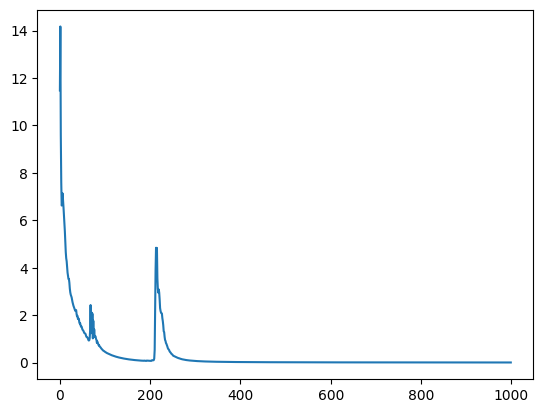

In [137]:
# identity matrix --> transmitter --> identity channel --> reciever --> identity matrix
import numpy as np
import torch
import matplotlib.pyplot as plt

input_size = 256
hidden_size = 128
channel_size = 2
channel_func = lambda x: x

model = TransmitterRecieverModel(input_size,hidden_size,channel_size,channel_func)

input_data = torch.randint(0, input_size, (input_size,), dtype=torch.long)

input_data_one_hot = torch.tensor(np.eye(input_size)[input_data],dtype=torch.float32)

training_loss = model.train_model(input_data_one_hot,input_data, learning_rate=0.1,epochs=1000)

output = model.evaluate(torch.tensor(input_data_one_hot,dtype=torch.float32))
print("Input Data: ")
print(input_data)
print("Output Data: ")
print(output)

plt.figure()
plt.plot(training_loss)
plt.show()

<h3>AutoEncoder Attempt #2 - With sliding window & Fiber Channel</h3>

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import json
from torch.utils.data import TensorDataset, DataLoader

# -----------------------------------------------------------------------------
def loader(weights_filepath, params_filepath):
    weights = torch.load(weights_filepath, weights_only=True, map_location=torch.device('cpu'))
    with open(params_filepath, "r") as f:
        params = json.load(f)
    return weights, params

# Load model weights and parameters
weights, params = loader(
    r"C:\Users\tomha\Documents\Capstone D2 - PC\Constellation\QPSK\Wider\model_weights.pth",
    r"C:\Users\tomha\Documents\Capstone D2 - PC\Constellation\QPSK\Wider\best_params.json"
)


In [64]:
class AutoEncoderV2(nn.Module):
    def __init__(self, alphabet_size, hidden_size, channel_size, channel_func, window_length):
        """
        Args:
            alphabet_size (int): Dimensionality of one-hot vectors (alphabet size).
            hidden_size (int): Hidden layer dimension.
            channel_size (int): Dimension of the transmitter output (e.g., 2 for I/Q).
            channel_func (callable): The fiber channel function. It expects an input of size (2 * window_length).
            window_length (int): Number of symbols per window.
        """
        super().__init__()
        self.alphabet_size = alphabet_size      # e.g., 4
        self.window_length = window_length        # e.g., 512
        self.channel_size = channel_size          # e.g., 2 (I/Q)

        # Transmitter: processes one symbol at a time.
        self.transmitter_fc1 = nn.Linear(alphabet_size, hidden_size)
        self.transmitter_fc2 = nn.Linear(hidden_size, channel_size)

        self.channel_function = channel_func

        # Receiver: decodes the channel output back to logits over the alphabet.
        self.reciever_fc1 = nn.Linear(channel_size, hidden_size)
        self.reciever_fc2 = nn.Linear(hidden_size, alphabet_size)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (total_length, alphabet_size), where total_length is divisible by window_length.
        Returns:
            A tensor of shape (num_windows, alphabet_size), where each row corresponds to the receiver's output for that window.
        """
        # Group input into non-overlapping windows.
        num_windows = x.shape[0] // self.window_length
        # x_windows shape: (num_windows, window_length, alphabet_size)
        x_windows = x.view(num_windows, self.window_length, self.alphabet_size)
        
        # Process each window individually through the transmitter,
        # and store the flattened outputs.
        flattened_windows = []
        for i in range(num_windows):
            # Get the i-th window. Shape: (window_length, alphabet_size)
            window = x_windows[i]
            
            # Process each symbol in the window through the transmitter.
            # tx_hidden shape: (window_length, hidden_size)
            tx_hidden = torch.sigmoid(self.transmitter_fc1(window))
            # Map each symbol to an I/Q pair. Shape: (window_length, channel_size)
            tx_symbols = self.transmitter_fc2(tx_hidden)
            
            # Flatten the window to a vector. Shape: (1, window_length * channel_size)
            window_flat = tx_symbols.view(1, -1)
            flattened_windows.append(window_flat)
        
        # Concatenate the flattened windows to form a batch.
        # Shape: (num_windows, window_length * channel_size)
        batch_flat = torch.cat(flattened_windows, dim=0)
        
        # Pass the entire batch of flattened windows through the fiber channel.
        # channel_out shape: (num_windows, channel_size)
        channel_out = self.channel_function(batch_flat)
        
        # Now, process each window individually through the receiver.
        window_outputs = []
        for i in range(num_windows):
            # Get the i-th channel output (a single window's output).
            ch_out = channel_out[i].unsqueeze(0)  # Shape: (1, channel_size)
            # Decode using the receiver.
            rx_hidden = torch.sigmoid(self.reciever_fc1(ch_out))
            rx_output = self.reciever_fc2(rx_hidden)  # Shape: (1, alphabet_size)
            window_outputs.append(rx_output)
        
        # Concatenate the decoded outputs from all windows.
        # Final shape: (num_windows, alphabet_size)
        outputs = torch.cat(window_outputs, dim=0)
        return outputs


    def evaluate(self, x):
        with torch.no_grad():
            output = self.forward(x)
            output_soft = F.softmax(output, dim=-1)
            preds = torch.argmax(output_soft, dim=-1)
            return preds

    def get_tx_symbols(self, x):
        """
        Returns the transmitter (I/Q) output for each symbol, before the channel.
        x: shape (total_length, alphabet_size).
        Returns: shape (num_windows*window_length, channel_size).
        """
        self.eval()
        with torch.no_grad():
            num_windows = x.shape[0] // self.window_length
            x_windows = x.view(num_windows, self.window_length, self.alphabet_size)
            
            tx_symbols_list = []
            for i in range(num_windows):
                window = x_windows[i]   # (window_length, alphabet_size)
                tx_hidden = torch.sigmoid(self.transmitter_fc1(window))
                tx_syms = self.transmitter_fc2(tx_hidden)    # (window_length, channel_size)
                tx_symbols_list.append(tx_syms)
            
            # Concatenate all windows
            tx_symbols_all = torch.cat(tx_symbols_list, dim=0)  # (num_windows*window_length, channel_size)
        return tx_symbols_all
    
    def get_channel_output(self, x):
        """
        Passes data through the transmitter and channel, returning the 
        channel's final I/Q for each window (one point per window).
        
        x: shape (total_length, alphabet_size).
        Returns: shape (num_windows, channel_size).
        """
        self.eval()
        with torch.no_grad():
            num_windows = x.shape[0] // self.window_length
            x_windows = x.view(num_windows, self.window_length, self.alphabet_size)
            
            flattened_windows = []
            for i in range(num_windows):
                window = x_windows[i]   # (window_length, alphabet_size)
                tx_hidden = torch.sigmoid(self.transmitter_fc1(window))
                tx_syms   = self.transmitter_fc2(tx_hidden)  # (window_length, channel_size)
                window_flat = tx_syms.view(1, -1)            # (1, window_length*channel_size)
                flattened_windows.append(window_flat)
    
            batch_flat = torch.cat(flattened_windows, dim=0)   # (num_windows, window_length*channel_size)
            channel_out = self.channel_function(batch_flat)    # (num_windows, channel_size)
        return channel_out



    def train_model(self, x, y, epochs, learning_rate):
        """
        Args:
            x: Tensor of shape (total_length, alphabet_size)
            y: Tensor of shape (num_windows,) with the target symbol (class index) for each window.
        """
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        loss_history = []

        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = self.forward(x)  # Shape: (num_windows, alphabet_size)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            loss_history.append(loss.item())
            if epoch % 100 == 0:
                print(f"Epoch {epoch} Loss: {loss.item():.4f}")

        # Plot the loss over epochs.
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 5))
        plt.plot(loss_history, label="Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss over Epochs")
        plt.legend()
        plt.show()
        return loss_history


In [66]:
# Define the wider model
class FiberOpticFNN2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(FiberOpticFNN2, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )
    def forward(self, x):
        return self.fc(x)

# Define the deeper model
class FiberOpticFNN1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        super(FiberOpticFNN1, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

        
# Set up the fiber channel.
channel = FiberOpticFNN2(1024, params["hidden_dim"], 2, params["dropout"])
channel.load_state_dict(weights["model weights"], strict=False)
channel_func = lambda x: channel.forward(x)


Epoch 0 Loss: 2.7961
Epoch 100 Loss: 2.3974
Epoch 200 Loss: 2.0300
Epoch 300 Loss: 1.7617
Epoch 400 Loss: 1.5273
Epoch 500 Loss: 1.3529
Epoch 600 Loss: 1.2754
Epoch 700 Loss: 1.2094
Epoch 800 Loss: 1.1027
Epoch 900 Loss: 1.0204
Epoch 1000 Loss: 0.9650
Epoch 1100 Loss: 0.9389
Epoch 1200 Loss: 0.8842
Epoch 1300 Loss: 0.8174
Epoch 1400 Loss: 0.8122
Epoch 1500 Loss: 0.7782
Epoch 1600 Loss: 0.7148
Epoch 1700 Loss: 0.7773
Epoch 1800 Loss: 0.6662
Epoch 1900 Loss: 0.6462
Epoch 2000 Loss: 0.6259
Epoch 2100 Loss: 0.6750
Epoch 2200 Loss: 0.6625
Epoch 2300 Loss: 0.6376
Epoch 2400 Loss: 0.5736
Epoch 2500 Loss: 0.6948
Epoch 2600 Loss: 0.6048
Epoch 2700 Loss: 0.5984
Epoch 2800 Loss: 0.6026
Epoch 2900 Loss: 0.5713
Epoch 3000 Loss: 0.6403
Epoch 3100 Loss: 0.5555
Epoch 3200 Loss: 0.5991
Epoch 3300 Loss: 0.4753
Epoch 3400 Loss: 0.5281
Epoch 3500 Loss: 0.5664
Epoch 3600 Loss: 0.5091
Epoch 3700 Loss: 0.4867
Epoch 3800 Loss: 0.5173
Epoch 3900 Loss: 0.5621
Epoch 4000 Loss: 0.5436
Epoch 4100 Loss: 0.4414
Epoc

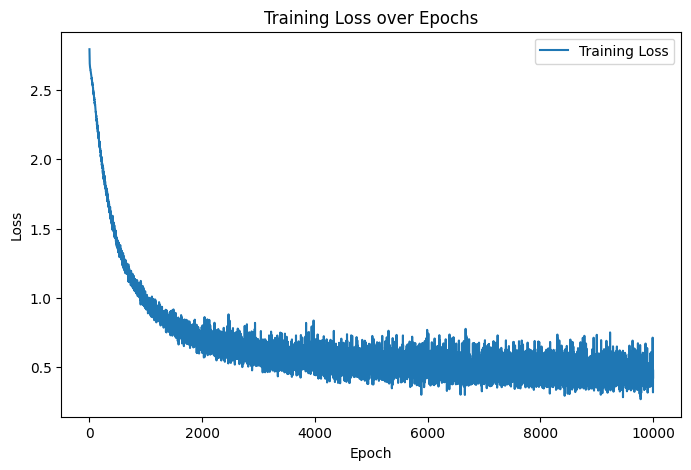

In [69]:
# Testing the autoencoder

#1 - Initialize the AutoEncoder

alphabet_size = 16   # One-hot vector dimension; using 4096 symbols.
hidden_size = 150
channel_size = 2        # I/Q components.
window_size = 512       # Each window has 1024 symbols.
total_length = 40960    


# Instantiate the autoencoder model.
model = AutoEncoderV2(
    alphabet_size=alphabet_size, 
    hidden_size=hidden_size, 
    channel_size=channel_size, 
    channel_func=channel_func, 
    window_length=window_size 
)


num_windows = total_length // window_size

# Generate one random symbol per window.
random_symbols = np.random.randint(0, alphabet_size, size=num_windows)  # shape: (80,)
# One-hot each symbol: shape (80, alphabet_size)
random_symbols_onehot = np.eye(alphabet_size)[random_symbols]
# Replicate each row 512 times => shape (80*512, alphabet_size) = (40960, 4)
repeated_symbols = np.repeat(random_symbols_onehot, repeats=window_size, axis=0)
# Build PyTorch tensor
input_tensor = torch.tensor(repeated_symbols, dtype=torch.float32)

# Target is just that single symbol for each window
target_tensor = torch.tensor(random_symbols, dtype=torch.long)

# --------------------------------------------------------------------------
# 5. Train the model
# --------------------------------------------------------------------------
loss_history = model.train_model(input_tensor, target_tensor, learning_rate=0.001, epochs=10000)


In [88]:
# Evaluate the model.
print("Evaluating the model...")
output = model.evaluate(input_tensor)

# Convert tensors to NumPy arrays.
y_true = target_tensor.cpu().numpy()
y_pred = output.cpu().numpy()

print("Target Symbols (middle of each window):")
print(y_true)
print("Output Predictions:")
print(y_pred)

# Calculate prediction accuracy.
correct = np.sum(y_true == y_pred)
total = y_true.shape[0]
accuracy = correct / total
print(f"Accuracy: {accuracy:.3f} ({correct}/{total})")


Evaluating the model...
Target Symbols (middle of each window):
[ 3 11 11 14  6  1 14  4  2 11  0  1  7  6  2 11 12  6  4 14 12 12  1  5
  0  8  5 13  5 14 15  5 12  7  2 11 12  5  6  8 14 10  3 15 10 14  1  4
  0  1  9 10  5  8  2  3  6  8  1  9  7  1  2 12 11  3  2 14 12 13 13  9
  2  9 14 12  8  6  2  5]
Output Predictions:
[ 3 11 11 14  6  1 14  4  2 11  0  1  7  6  2 11 12  2  0 14 12 12  1  5
  0  8  5  6  5 14 14 13 12  7  2 11 12  5  6  8 14 10  3 15 10 14  1  4
  0  1 12 14  5  8  2  3  6  8  1  9  7  1  2 12 11  3  2 14 12 13 13  9
  2 12 12 12  8  6  2  5]
Accuracy: 0.887 (71/80)


In [30]:
import numpy as np
import torch

# Let's assume your model is already defined and trained as `model`.
# We'll create a function that generates new test data:
def generate_test_data(num_windows, alphabet_size=8, window_size=512):
    """
    Generates new test data where each "logical" window is a single symbol
    repeated 512 times so that the channel sees the correct dimension.

    Returns:
        test_input_tensor: Tensor of shape (num_windows * window_size, alphabet_size)
        test_target_tensor: Tensor of shape (num_windows,)
    """
    # Generate random symbols (one per window).
    random_test_symbols = np.random.randint(0, alphabet_size, size=num_windows)
    # One-hot each symbol: shape (num_windows, alphabet_size)
    random_test_onehot = np.eye(alphabet_size)[random_test_symbols]
    # Replicate each row 512 times => shape (num_windows*512, alphabet_size)
    repeated_test_data = np.repeat(random_test_onehot, repeats=window_size, axis=0)
    
    # Build PyTorch tensor
    test_input_tensor = torch.tensor(repeated_test_data, dtype=torch.float32)
    test_target_tensor = torch.tensor(random_test_symbols, dtype=torch.long)
    return test_input_tensor, test_target_tensor

# Example usage:
num_test_windows = 100  # E.g., produce 20 new test windows.

# Generate the new test data
new_test_input, new_test_target = generate_test_data(num_test_windows, 
                                                     alphabet_size=alphabet_size, 
                                                     window_size=window_size)

# Evaluate the model on this new data
print("Evaluating on new test data...")
output_test = model.evaluate(new_test_input)
y_true_test = new_test_target.cpu().numpy()
y_pred_test = output_test.cpu().numpy()

print("New Test Target Symbols:")
print(y_true_test)
print("New Test Predictions:")
print(y_pred_test)

# Compute accuracy
correct_new = np.sum(y_true_test == y_pred_test)
total_new = y_true_test.shape[0]
accuracy_new = correct_new / total_new
print(f"New Test Accuracy: {accuracy_new:.3f} ({correct_new}/{total_new})")


Evaluating on new test data...
New Test Target Symbols:
[ 3  0 12 12  2 10 14  1  6 14  2 12 14  2 14 13  5  7 14 15  5 10  8 10
  5  3 10  7  6 15  4  7  8 15 14 15  6 10 13  8  0 14  7 11 10 11 13  4
 13  3  1  7 13  1  8  1 15 15  4  7  3  4  6 14 13  7 12 14  4 14 10  5
  7  1 15 12 10  6  9 12  8  0  2 10  2  1  5  9  7 15  1 11  4  0 11  4
  9  6 11  0]
New Test Predictions:
[ 3  3 12 12 12 12 14  3  6 14 12 12 12 12 14 12 12 12  3 12  5 12  3  5
 12  5 12 12  6 12 12 12 14 12 14 12  6 12 12  3 12 14 12 14 12 12 12 12
 12  5 14 12 12  5  3  5 12 12 12 12 12 12  6 14 12 12  5 14  5 14  5  5
 12 12 12 12 12  6 14 12  0  5 12 12 12  5 12  9 12  5 12 14 12  3 14 12
  9  6 14 14]
New Test Accuracy: 0.240 (24/100)


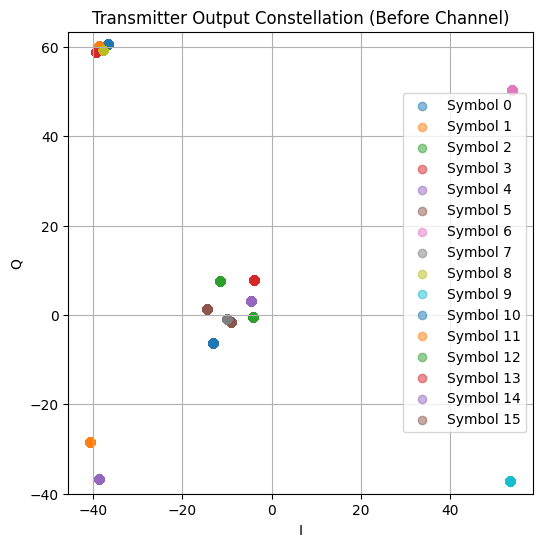

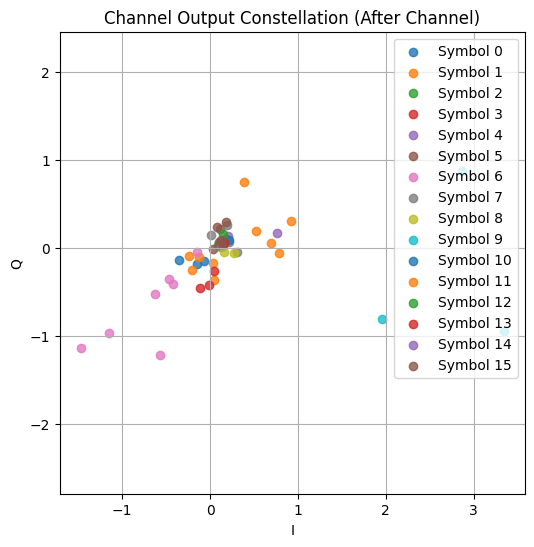

In [31]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Suppose 'model' is already instantiated and trained, and 'generate_test_data' is defined.

num_test_windows = 50
alphabet_size = 16
window_size = 512

new_test_input, new_test_target = generate_test_data(num_test_windows,
                                                     alphabet_size=alphabet_size,
                                                     window_size=window_size)

# 1) Get the transmitter output for each symbol (before channel).
tx_syms_all = model.get_tx_symbols(new_test_input)  # shape (num_windows*512, 2)
tx_syms_np   = tx_syms_all.cpu().numpy()

# 2) Get the channel output (one I/Q pair per window).
ch_out_all = model.get_channel_output(new_test_input)  # shape (num_windows, 2)
ch_out_np  = ch_out_all.cpu().numpy()

# Because each logical window is just one unique symbol repeated,
# we replicate the symbol IDs 512 times for the transmitter plot,
# and use them once for the channel-out plot.
symbol_ids_repeated = np.repeat(new_test_target.cpu().numpy(), window_size)
symbol_ids_single   = new_test_target.cpu().numpy()  # one per window

# We need at least 16 distinct colors for 16 symbols:
colors = [
    "red", "blue", "green", "orange", "purple", "brown", "cyan", "magenta",
    "pink", "gray", "olive", "lime", "navy", "yellow", "maroon", "gold"
]

# 3a) Plot the transmitter (before channel) constellation:
plt.figure(figsize=(6, 6))
for sym_id in range(alphabet_size):
    idx = (symbol_ids_repeated == sym_id)
    plt.scatter(
        tx_syms_np[idx, 0],
        tx_syms_np[idx, 1],
        label=f"Symbol {sym_id}",
        alpha=0.5
    )
plt.title("Transmitter Output Constellation (Before Channel)")
plt.xlabel("I")
plt.ylabel("Q")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

# 3b) Plot the channel output constellation (one point per window):
plt.figure(figsize=(6, 6))
for sym_id in range(alphabet_size):
    idx = (symbol_ids_single == sym_id)
    plt.scatter(
        ch_out_np[idx, 0],
        ch_out_np[idx, 1],
        label=f"Symbol {sym_id}",
        alpha=0.8
    )
plt.title("Channel Output Constellation (After Channel)")
plt.xlabel("I")
plt.ylabel("Q")
plt.grid(True)
plt.axis("equal")
plt.legend()
plt.show()

# Optionally compute final predictions and accuracy as well, similar to your code above.
